# 汽车边缘识别
    1.随机取汽车图片上的一小块patch,凡是取到了一个像素的汽车,就作为正例数据集,car
    2.随机取汽车图片上的一小块patch,凡是取到了非汽车区域,就作为负例数据集,noncar
    3.标注数据不仅仅是0和1,还需要训练汽车的边缘特征

In [1]:
import os
import os.path
from os import walk
from os.path import join
import numpy as np

base_path = '/atlas/home/zwpeng/kaggle/'

def get_picture(path):
    path0 = join(base_path + path)
    picture = []
    for _,_,filenames in walk(path0):
        for filename in filenames:
            file_prefix = os.path.splitext(filename)[0]
            if os.path.exists(join(path0, file_prefix + ".jpg")):
                picture.append(filename)
            elif os.path.exists(join(path0, file_prefix + ".gif")):
                picture.append(filename)
            else:
                print("路径不对或者没有这种格式的文件")
    return picture

In [2]:
car_pictures = get_picture("train")

mask_pictures = get_picture("train_masks")

len(car_pictures), len(mask_pictures)

(5088, 5088)

In [3]:
train_set = car_pictures[0:3801]
valid_set = car_pictures[3801:5068]
test_set = car_pictures[5068:5088]
len(train_set),len(valid_set),len(test_set)

(3801, 1267, 20)

    from sklearn.model_selection import StratifiedShuffleSplit

    # 把数据集切分成训练集和验证集
    # 使用 StratifiedShuffleSplit 来保证训练集和验证集拥有相同比例的tumor的小图片.
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(samples, samples["is_tumor"]):
            train_samples = samples.loc[train_index]
            validation_samples = samples.loc[test_index]

In [4]:
import openslide
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as image
import threading

class threadsafe_iter:
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()
    
    def __iter__(self):
        return self
    
    def __next__(self):
        with self.lock:
            return self.it.__next__()

def threadsafe_generator(f):
    def g(*args, **kw):
        return threadsafe_iter(f(*args, **kw))
    return g

@threadsafe_generator
def data_generator(data_set, batch_size=32, widths=128, heights=128):
    while True:
        images = []
        masks = []
        for i in range(batch_size):
            random_choice = np.random.choice(data_set)    # 从给定的数据集中随机选取一张
            random_choice_path = join(base_path, "train/" + random_choice)    # 获得该随机图片的路径
            random_mask_path = join(base_path, "train_masks/" + (random_choice.split("."))[0] + "_mask.gif")    # 获得该随机图片对应的mask

            car_pic = image.imread(random_choice_path)    # 读取该随机图片
            mask_pic = image.imread(random_mask_path)    # 读取该随机图片对应的mask

            random_num = np.random.random(1)
    #         print("产生的随机数是:%s"%random_num)
            if random_num > 0.5:    # 必须取到一张包含汽车至少一个像素的图片
                random_x = np.random.randint(0, car_pic.shape[1] - widths)
                random_y = np.random.randint(0, car_pic.shape[0] - heights)
                slide = openslide.open_slide(random_mask_path)
                slide1 = slide.read_region((random_x,random_y), 0, (widths, heights))
                slide_arr = np.array(slide1.convert("L"))
                slide_y, slide_x = np.nonzero(slide_arr)
                while len(slide_x) == 0:
                    random_x = np.random.randint(0, car_pic.shape[1] - widths)
                    random_y = np.random.randint(0, car_pic.shape[0] - heights)
                    slide = openslide.open_slide(random_mask_path)
                    slide1 = slide.read_region((random_x,random_y), 0, (widths, heights))
                    slide_arr = np.array(slide1.convert("L"))
                    slide_y, slide_x = np.nonzero(slide_arr)
                masks.append((slide_arr>0).astype(int))
                img = (openslide.open_slide(random_choice_path)).read_region((random_x,random_y),0,(widths,heights))
                images.append(np.array(img.convert("RGB")))
            else:
                random_x = np.random.randint(0, car_pic.shape[1] - widths)
                random_y = np.random.randint(0, car_pic.shape[0] - heights)
                slide = openslide.open_slide(random_mask_path)
                slide1 = slide.read_region((random_x,random_y), 0, (widths, heights))
                slide_arr = np.array(slide1.convert("L"))
                slide_y, slide_x = np.nonzero(slide_arr)
                while len(slide_x) != 0:
                    random_x = np.random.randint(0, car_pic.shape[1] - widths)
                    random_y = np.random.randint(0, car_pic.shape[0] - heights)
                    slide = openslide.open_slide(random_mask_path)
                    slide1 = slide.read_region((random_x,random_y), 0, (widths, heights))
                    slide_arr = np.array(slide1.convert("L"))
                    slide_y, slide_x = np.nonzero(slide_arr)
                masks.append(np.zeros((widths,heights)))
                img = (openslide.open_slide(random_choice_path)).read_region((random_x,random_y),0,(widths,heights))
                images.append(np.array(img.convert("RGB")))

        X_train = np.array(images)
        y_train = np.array(masks)
    #     print(y_train.shape[0],y_train.shape[1])
        y_train = to_categorical(y_train, num_classes=2).reshape(y_train.shape[0], widths, heights, 2)
        yield X_train,y_train

Using TensorFlow backend.


In [9]:
%time exampl_X, example_y = next(data_generator(train_set,batch_size=32,widths=128,heights=128))

CPU times: user 3.51 s, sys: 149 ms, total: 3.66 s
Wall time: 4.28 s


In [10]:
exampl_X.shape, example_y.shape

((32, 128, 128, 3), (32, 128, 128, 2))

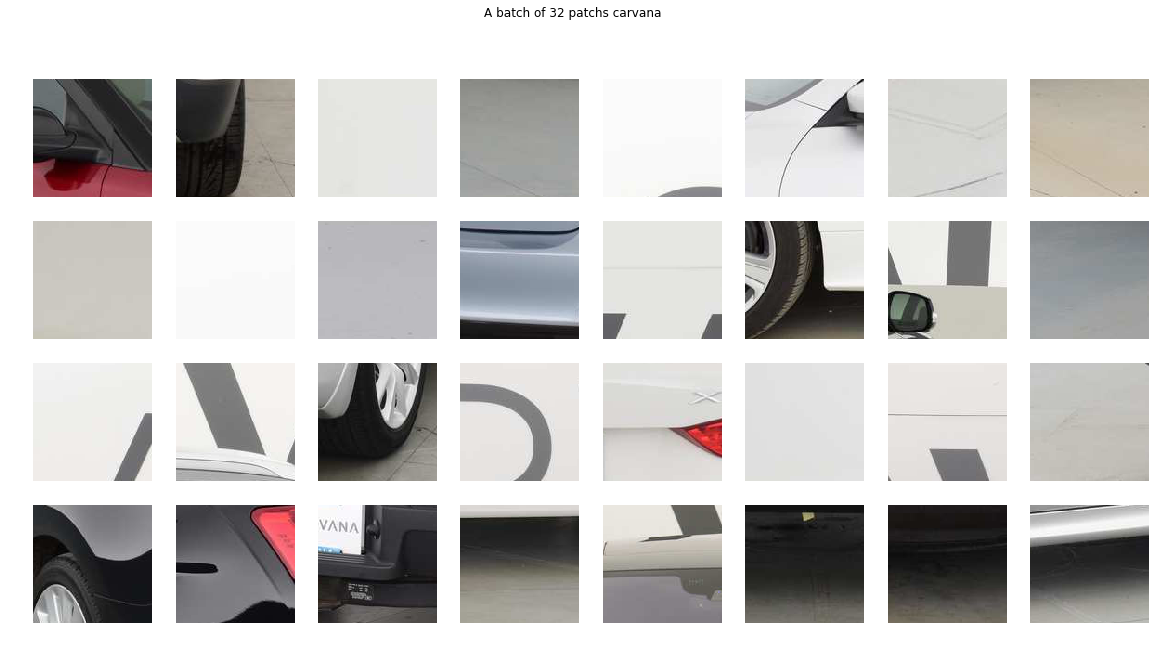

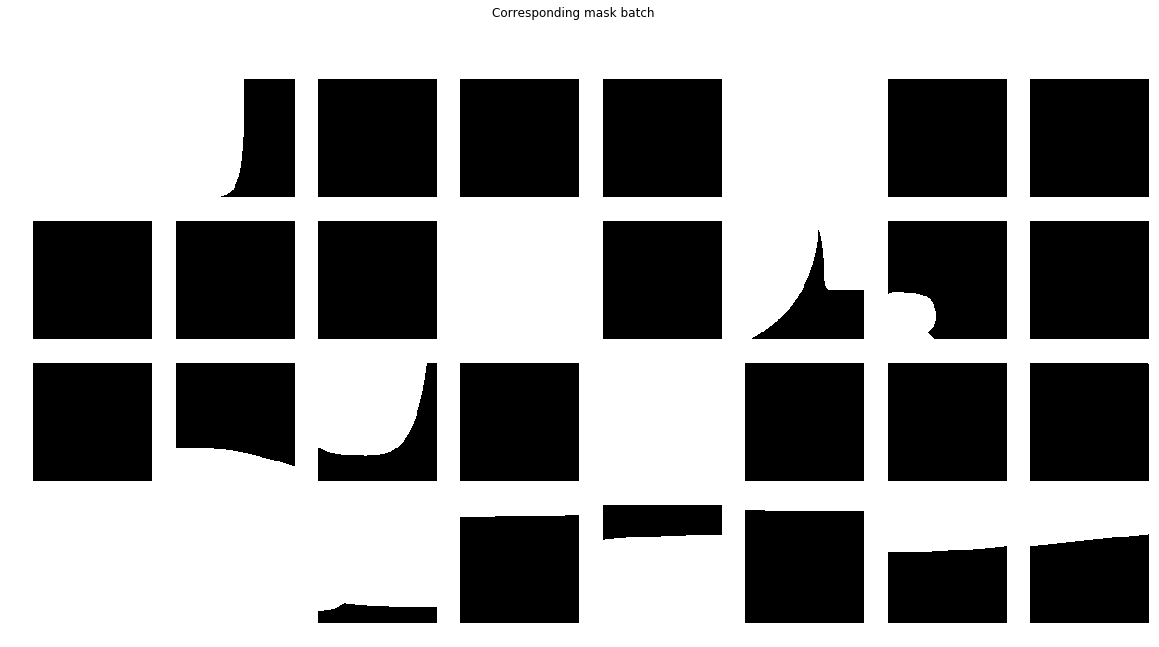

In [11]:
%matplotlib inline
f, axes = plt.subplots(4, 8, figsize=(20,10));
ax = axes.flatten();
for i in range(exampl_X.shape[0]):
    _ = ax[i].imshow(exampl_X[i]);
    _ = ax[i].axis('off');
f.suptitle('A batch of 32 patchs carvana');

f, axes = plt.subplots(4, 8, figsize=(20, 10));
ax = axes.flatten();
for i in range(example_y.shape[0]):
    _ = ax[i].imshow(example_y[i].argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    _ = ax[i].axis('off');
f.suptitle('Corresponding mask batch');

搭建深度学习网络模型

In [5]:
from keras.models import Sequential
from keras.layers import Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(128,128,3)))
model.add(Convolution2D(100, (3, 3), strides=(2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Convolution2D(200, (3, 3), strides=(2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Convolution2D(300, (3, 3), activation='relu', padding='same'))
model.add(Convolution2D(300, (3, 3), activation='relu', padding='same'))

model.add(Dropout(0.1))
model.add(Convolution2D(2, (1, 1)))
model.add(Conv2DTranspose(2, (31, 31), strides=(16,16), activation='softmax', padding='same'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 100)       2800      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 200)       180200    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 200)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 300)         540300    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 300)         810300    
__________

In [7]:
from datetime import datetime
from keras.callbacks import CSVLogger

epochs = 80
batch_size = 64

start_time = datetime.now()
csvlogger = CSVLogger('train_64_200.log', append=True)

model.fit_generator(data_generator(train_set,batch_size=batch_size),
                    steps_per_epoch=200,
                    epochs=epochs,
                    validation_data=data_generator(valid_set,batch_size=batch_size),
                    validation_steps=80,
                    verbose=1,
                    workers=40,
                    callbacks=[csvlogger])
model.save('model_64_200.h5')
end_time = datetime.now()
print('Model Training Time:%.1f minutes'%((end_time-start_time).seconds / 60,))

Epoch 1/80
200/200 [==============================] - 2013s - loss: 0.3668 - acc: 0.8612 - val_loss: 0.2572 - val_acc: 0.9072
Epoch 2/80
200/200 [==============================] - 1721s - loss: 0.2445 - acc: 0.9100 - val_loss: 0.2153 - val_acc: 0.9222
Epoch 3/80
200/200 [==============================] - 1874s - loss: 0.2217 - acc: 0.9187 - val_loss: 0.2123 - val_acc: 0.9240
Epoch 4/80
200/200 [==============================] - 1861s - loss: 0.2051 - acc: 0.9254 - val_loss: 0.2127 - val_acc: 0.9277
Epoch 5/80
200/200 [==============================] - 1815s - loss: 0.1907 - acc: 0.9309 - val_loss: 0.1784 - val_acc: 0.9359
Epoch 6/80
200/200 [==============================] - 1885s - loss: 0.1779 - acc: 0.9354 - val_loss: 0.1645 - val_acc: 0.9398
Epoch 7/80
200/200 [==============================] - 1827s - loss: 0.1743 - acc: 0.9364 - val_loss: 0.1446 - val_acc: 0.9487
Epoch 8/80
200/200 [==============================] - 1825s - loss: 0.1545 - acc: 0.9439 - val_loss: 0.1774 - val_acc:

200/200 [==============================] - 2411s - loss: 0.0565 - acc: 0.9806 - val_loss: 0.0669 - val_acc: 0.9783
Epoch 66/80
200/200 [==============================] - 2573s - loss: 0.0504 - acc: 0.9830 - val_loss: 0.0598 - val_acc: 0.9801
Epoch 67/80
200/200 [==============================] - 2360s - loss: 0.0524 - acc: 0.9823 - val_loss: 0.0547 - val_acc: 0.9821
Epoch 68/80
200/200 [==============================] - 2278s - loss: 0.0499 - acc: 0.9828 - val_loss: 0.0524 - val_acc: 0.9823
Epoch 69/80
200/200 [==============================] - 2325s - loss: 0.0529 - acc: 0.9818 - val_loss: 0.0604 - val_acc: 0.9793
Epoch 70/80
200/200 [==============================] - 2011s - loss: 0.0539 - acc: 0.9815 - val_loss: 0.0589 - val_acc: 0.9811
Epoch 71/80
200/200 [==============================] - 1888s - loss: 0.0484 - acc: 0.9834 - val_loss: 0.0571 - val_acc: 0.9811
Epoch 72/80
200/200 [==============================] - 1835s - loss: 0.0500 - acc: 0.9827 - val_loss: 0.0509 - val_acc: 0.9

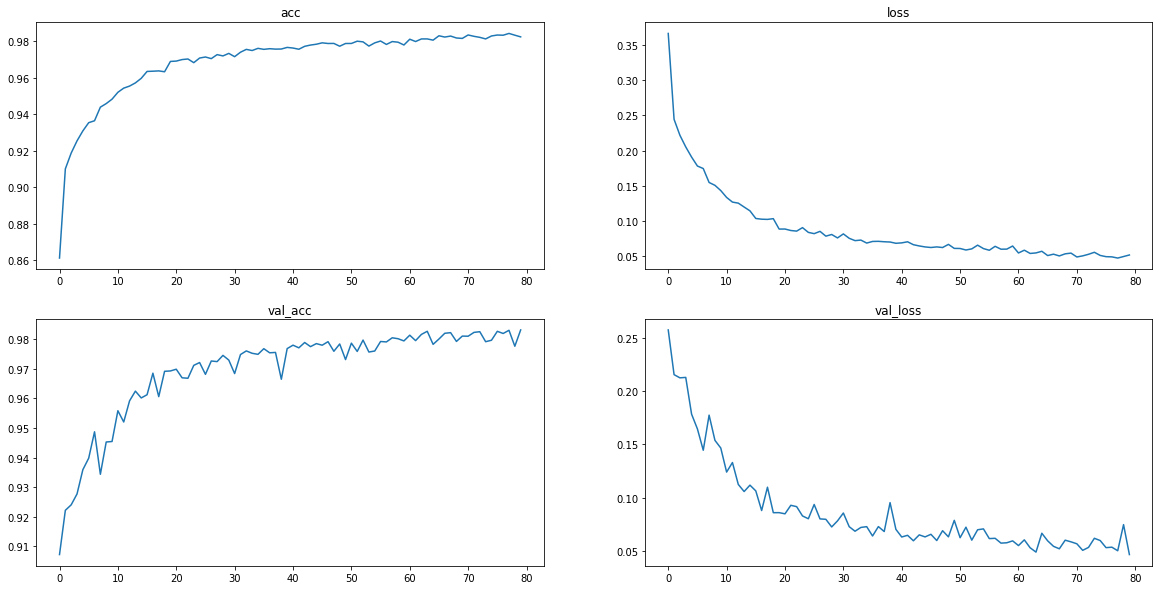

In [9]:
# 自定义网络层训练效果
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


train_log = open("train_64_200.log")
log_line = train_log.readlines()
# log_line
epoch = []
acc = []
loss = []
val_acc = []
val_loss = []

for i in range(len(log_line)):
    if i<len(log_line)-1:
        line_list = list(eval(log_line[i+1]))
        epoch.append(line_list[0])
        acc.append(line_list[1])
        loss.append(line_list[2])
        val_acc.append(line_list[3])
        val_loss.append(line_list[4])

fig, axes = plt.subplots(2,2,figsize=(20,10))    # 自定义每个小图的尺寸
ax = axes.ravel()
ax[0].plot(epoch,acc)
ax[0].set_title('acc')

ax[1].plot(epoch,loss)
ax[1].set_title('loss')
ax[2].plot(epoch,val_acc)
ax[2].set_title('val_acc')
ax[3].plot(epoch,val_loss)
ax[3].set_title('val_loss')

In [10]:
def predict_from_model(patch, model):
    
    prediction = model.predict(patch.reshape(1, 128, 128, 3))
    prediction = prediction[:, :, :, 1].reshape(128, 128)
    return prediction

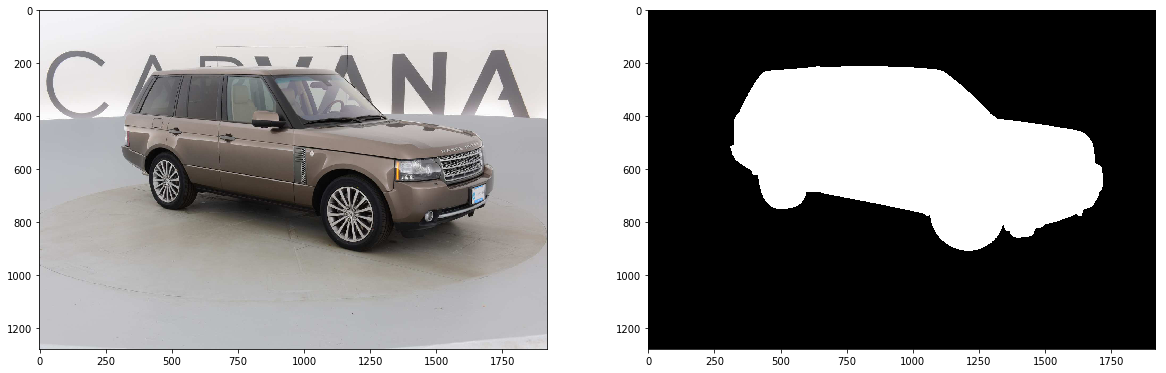

In [11]:
%matplotlib inline
from PIL import Image

random_choice = np.random.choice(test_set)    # 从给定的数据集中随机选取一张
random_choice_path = join(base_path, "train/" + random_choice)    # 获得该随机图片的路径
random_mask_path = join(base_path, "train_masks/" + (random_choice.split("."))[0] + "_mask.gif")    # 获得该随机图片对应的mask

car_pic = Image.open(random_choice_path)    # 读取该随机图片
mask_pic = Image.open(random_mask_path)    # 读取该随机图片对应的mask

f, axes = plt.subplots(1,2,figsize=(20,20))
ax = axes.ravel()
ax[0].imshow(car_pic)
ax[1].imshow(mask_pic)

np.append
np.hstack,np.vstack
np.concatenate
np.column_stack()
np.delete()

In [21]:
from keras.models import load_model



model = load_model('./model_64_200.h5')

widths, heights = 128, 128

pat_pred = np.zeros((128, 1920))

if (car_pic.size[0]-(car_pic.size[0]//128)*128) !=0:
    r

for i in range(car_pic.size[1]//heights):
    pat_pre = np.zeros((128,128))
    
    for j in range(car_pic.size[0]//widths):
        pat = (Image.open(random_choice_path)).crop((j*widths,i*widths,(j+1)*widths,(i+1)*heights))
        pat_array = np.array(pat)
        pre_pat = predict_from_model(pat_array, model)
        
#         pat_set[i] = np.concatenate([pat_set[i], pat_array])
        pat_pre = np.hstack((pat_pre, pre_pat))
        
    pat_pred = np.vstack((pat_pred, pat_pre))
#         _= ax[j].imshow(patch)
# (np.array(pat_set)).shape
(np.array(pat_pred)).shape

(1408, 1920)

(1280, 1918)


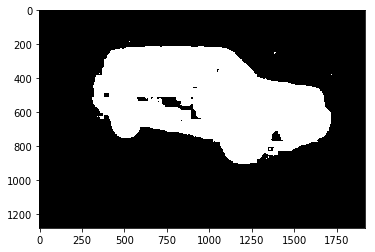

In [35]:
# from keras.preprocessing import image
import matplotlib.pyplot as plt

predic01 = np.array(pat_pred)
for i in range(128):
    predic01 = np.delete(predic01,i,1)
    predic01 = np.delete(predic01,i,0)

predic02 = np.column_stack((predic01,(np.zeros((1280,126))).astype(int)))    
print(predic02.shape)

# img03 = patch_pre[56].reshape(128, 128)
# img03.shape
# img04 = image.array_to_img(img03)
plt.imshow((predic02>0.5).astype(np.int),cmap='gray',vmin=0,vmax=1)
plt.show()
